In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns


DATA_PATH_2022 = '../data/targetstation46240/46240h2022.txt'
DATA_PATH_2021 = '../data/raw/46266h2021.txt'
DATA_PATH_2020 = '../data/raw/46266h2020.txt'
DATA_PATH_2019 = '../data/raw/46266h2019.txt'

# Format 2019 - 2022 Historical Data

For the baseline model, we will only use wave related data as features. We have also downloaded ocean current data from the same buoy location, however, we do not want to over over-featurize given the total size of the dataset and MLP model.

Most of the functions in this section format the data text files into dataframes, handle the type conversions, and drop columns we will not use.

In [3]:
def text_to_dataframe(data_path):
    historical_data = pd.read_csv(data_path, delim_whitespace=True, header=0)

    # drop the units row
    units = historical_data.iloc[0]
    historical_data.drop(0, inplace=True)

    # reset the index since we are now missing a row
    historical_data = historical_data.reset_index(drop=True)

    return units, historical_data

There is a little data cleaning we need to do here. As you can see below (where we look at the heads of the dataframes), the values for certain columns are all 99.0 or 9999.0. These values signal a missing value. In the case of our data, the buoy likely does not have the proper instruments to capture these values. To fix this, we will simply drop the columns.

Another issue is that we just loaded in a text file, so all the values in the dataframe are strings. The models we train later in the script need numerical data. We can use some useful functions from the pandas library to convert it to a digestable format for our future model.

To make window slicing easier for the time series data, I only keep measurements on the start of each hour. The original dataframes contain measurements for every 30 minutes. Given that there are marginal changes (from initial observations) every 30 minutes, we only consider inputs that are seperated by one hour of time for the baseline models. We accomplish this with the last function in the block below.

We also drop certain columns to simplify our feature set for the baseline mode. For detailed descriptions of each feature, please refer [here](https://www.ndbc.noaa.gov/faq/measdes.shtml#stdmet).

In [4]:
# TODO: Explain why we are dropping wind direction, wind speed, gust speed, sea level pressure, dewpoint temp, visibility, and tide
def drop_cols(dataframe, columns_to_drop=['WDIR', 'WSPD', 'GST', 'PRES', 'DEWP', 'VIS', 'TIDE']):
    dataframe.drop(columns=columns_to_drop, inplace=True)

def convert_to_numerical_data(dataframe):
    # Convert all columns to numerical values
    dataframe.apply(pd.to_numeric)

    # Convert specific columns to integers
    columns_to_convert_to_int = ['#YY', 'MM', 'DD', 'hh', 'mm']
    for col in columns_to_convert_to_int:
        dataframe[col] = dataframe[col].astype(int)

def convert_to_hourly(dataframe):
    # Drop rows where 'mm' column is not 0
    drop_indices = dataframe[dataframe['mm'] != 0].index
    dataframe.drop(drop_indices, inplace=True)

For each year, we seem to have some missing values (see the smaller number of rows for the dataframe compared to 2020 and 2022). The missing values likely reflect certain times when the sensors of the buoy were malfuncitoning. Because we are dealing with time series data, where datapoints need to be ordered sequentially, we need to account for these missing rows when processing the dataset.

The function below is responsible for finding where the measurement between the ith row and i-1th row is greater than 60 minutes. We will have to account for these rows when preprocessing the data.

Note: We check for 60 minute differences after dropping all measurements that are not taken on the hour! See the other functions below to get a better idea of how we accomplish this.

In [5]:
def check_for_missing_rows(dataframe):
    # Rename columns for compatibility with pd.to_datetime()
    dataframe = dataframe.rename(columns={
        '#YY': 'year',
        'MM': 'month',
        'DD': 'day',
        'hh': 'hour',
        'mm': 'minute'
    })

    # Convert the separate year, month, day, hour, minute columns into a single datetime column
    dataframe['datetime'] = pd.to_datetime(dataframe[['year', 'month', 'day', 'hour', 'minute']])

    missing_indices = []

    # Iterate over rows and check for a time difference of more than 30 minutes
    for i in range(1, dataframe.shape[0]):
        time_diff = dataframe.iloc[i]['datetime'] - dataframe.iloc[i-1]['datetime']
        if time_diff > pd.Timedelta(minutes=60):
            missing_indices.append(i)

    return missing_indices

Now, we need to split the data into time series training and label targets. 

For this step, we need to decide our forecasting window. Given that we are attempting to build an open source wave forecasting model for surfers, we will aim to predict the mean significant wave height in 24-48 hours.

Let's start with a 24 hour lead time. With this decided, we can format a dataset for supervised learning. Our x's will be vectors containg the set of features we specify measured at each hour for a certain amount hours. In the code below, we have 4 features measured at each hour for 24 hours. Thus, each x_i will be 96 x 1 ((4 * 24) x 1). The corresponding label will just be a scalar representing the 'WVHT' value 24 hours ahead of the last hour measurements were taken in the x_i vector.

In [6]:
# TODO: Increase lead to 48 / 96
# TODO: Discuss why wave height, dominant wave period, average wave period, and wave direction are the features we are using
def build_supervised_learning_dataset(dataframe, missing_indices, feature_set=['WVHT', 'DPD', 'APD', 'MWD'], window=24, lead=24):
    # Convert missing_indices to a set for faster lookup
    missing_set = set(missing_indices)

    X, y = [], []

    for i in range(dataframe.shape[0] - window - lead + 1):
        # Check if any of the indices in the current slice are in the missing set
        if any([(i + j) in missing_set for j in range(window)]):
            continue
        
        # Here we grab the window of values for each feature
        x_i = dataframe.iloc[i : i + window][feature_set].to_numpy()

        # Reshape the array so it can be a row vector of X (1 X 24 * 4) -> (1 x 96)
        x_i = x_i.flatten()

        # Only fetch the significant wave height value for the label
        y_i = dataframe.iloc[i + window + lead - 1]['WVHT']

        X.append(x_i)
        y.append(y_i)

    return np.array(X), np.array(y)

---

### 2019

From some exploration of the data from 2019, we can see that it starts in December. As a result, the dataframe is smaller compared to other years.

In [7]:
_, historical_data_2019 = text_to_dataframe(DATA_PATH_2019)

print(f'shape: {historical_data_2019.shape}')

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/46266h2019.txt'

In [8]:
drop_cols(historical_data_2019)

convert_to_numerical_data(historical_data_2019)

convert_to_hourly(historical_data_2019)

historical_data_2019.head()

NameError: name 'historical_data_2019' is not defined

In [9]:
missing_indices_2019 = check_for_missing_rows(historical_data_2019)

len(missing_indices_2019)

NameError: name 'historical_data_2019' is not defined

In [10]:
X_2019, y_2019 = build_supervised_learning_dataset(historical_data_2019, missing_indices_2019)

f'X shape: {X_2019.shape} y shape: {y_2019.shape}'

NameError: name 'historical_data_2019' is not defined

---

### 2020

In [11]:
_, historical_data_2020 = text_to_dataframe(DATA_PATH_2020)

print(f'shape: {historical_data_2020.shape}')

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/46266h2020.txt'

In [12]:
drop_cols(historical_data_2020)

convert_to_numerical_data(historical_data_2020)

convert_to_hourly(historical_data_2020)

historical_data_2020.head()

NameError: name 'historical_data_2020' is not defined

In [13]:
missing_indices_2020 = check_for_missing_rows(historical_data_2020)

len(missing_indices_2020)

NameError: name 'historical_data_2020' is not defined

In [14]:
X_2020, y_2020 = build_supervised_learning_dataset(historical_data_2020, missing_indices_2020)

f'X shape: {X_2020.shape} y shape: {y_2020.shape}'

NameError: name 'historical_data_2020' is not defined

---

### 2021

In [15]:
_, historical_data_2021 = text_to_dataframe(DATA_PATH_2021)

print(f'shape: {historical_data_2021.shape}')

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/46266h2021.txt'

In [16]:
drop_cols(historical_data_2021)

convert_to_numerical_data(historical_data_2021)

convert_to_hourly(historical_data_2021)

historical_data_2021.head()

NameError: name 'historical_data_2021' is not defined

In [17]:
missing_indices_2021 = check_for_missing_rows(historical_data_2021)

len(missing_indices_2021)

NameError: name 'historical_data_2021' is not defined

In [18]:
X_2021, y_2021 = build_supervised_learning_dataset(historical_data_2021, missing_indices_2021)

f'X shape: {X_2021.shape} y shape: {y_2021.shape}'

NameError: name 'historical_data_2021' is not defined

---

### 2022

In [19]:
_, historical_data_2022 = text_to_dataframe(DATA_PATH_2022)

print(f'shape: {historical_data_2022.shape}')

shape: (16436, 18)


In [20]:
drop_cols(historical_data_2022)

convert_to_numerical_data(historical_data_2022)

convert_to_hourly(historical_data_2022)

historical_data_2022.head()

,#YY,MM,DD,hh,mm,WVHT,DPD,APD,MWD,ATMP,WTMP


In [20]:
missing_indices_2022 = check_for_missing_rows(historical_data_2022)

len(missing_indices_2022)

29

In [1]:
X_2022, y_2022 = build_supervised_learning_dataset(historical_data_2022, missing_indices_2022)

f'X shape: {X_2022.shape} y shape: {y_2022.shape}'
X_2022

NameError: name 'build_supervised_learning_dataset' is not defined



# Visualizing Historical Data

To increase the number of datapoints we have for the baseline, we will aggregate data recorded by the same buoy for 2020, 2021, and 2022. In the future, we will increase the number of years we aggregate data accross to increase the size of the training set.

In [22]:
# Concatenate the DataFrames vertically
all_historical_data = pd.concat([historical_data_2019, historical_data_2020, historical_data_2021], axis=0).reset_index(drop=True)

all_historical_data.head()

,#YY,MM,DD,hh,mm,WVHT,DPD,APD,MWD,ATMP,WTMP
0,2019,12,6,18,0,0.72,14.29,8.10,244,999.0,16.6
1,2019,12,6,19,0,0.65,14.29,7.83,240,999.0,16.9
2,2019,12,6,20,0,0.67,12.50,7.49,251,999.0,17.3
3,2019,12,6,21,0,0.68,11.11,7.47,262,999.0,17.1
4,2019,12,6,22,0,0.66,14.29,6.73,239,999.0,16.7


Before we get into processing the data into training, dev, and test sets, let's visualize the different feature columns. By examining their distributions, we can make more informed decisions for out data prepocessing steps and model architecture.

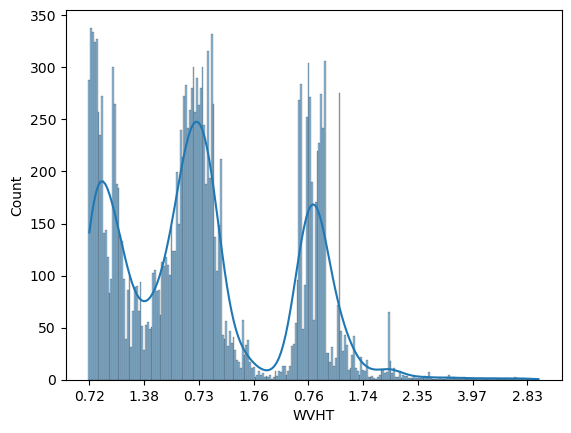

In [23]:

sns.histplot(all_historical_data.WVHT, kde=True)
ax = plt.gca()  # get the current axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.show()

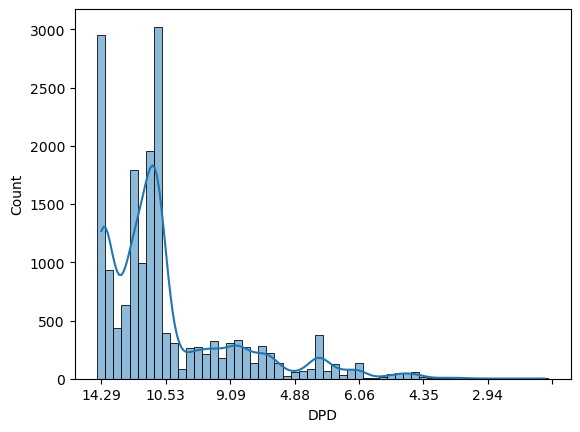

In [24]:
sns.histplot(all_historical_data.DPD , kde=True)
ax = plt.gca()  # get the current axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.show()

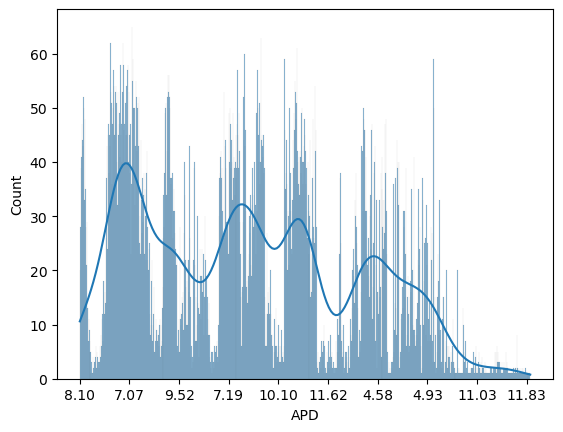

In [25]:
sns.histplot(all_historical_data.APD, kde=True)
ax = plt.gca()  # get the current axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.show()

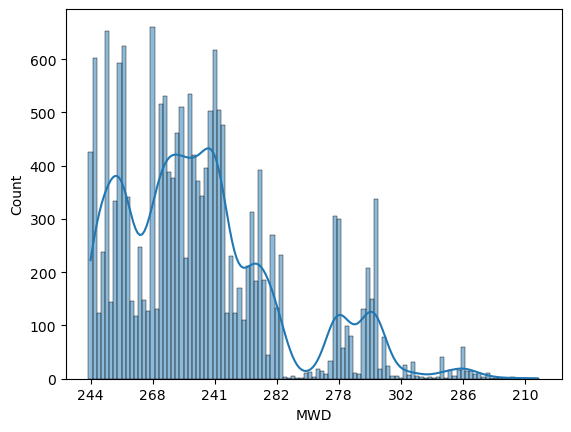

In [26]:
sns.histplot(all_historical_data.MWD, kde=True)
ax = plt.gca()  # get the current axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.show()

One thing to note about the plots above is the shape of the distributions and their scales. Each feature set is on a different scale, as shown by the x-axis values. We will need to take this into consideration when training different regression models.

With our feature set visualized, we can now move into preprocessing the dataset for training out baseline model. The steps taken below are specific for the baseline model (Linear Regression and MLP). When we used models specifically designed for time-dependent data, like an LSTM, we will have to process and store the data in a slightly different way.

# Baseline Model Training

For now, we will hold out all of the year 2022 as our test set for our final model.

In [48]:
X = np.vstack((X_2019, X_2020, X_2021))

y = np.concatenate((y_2019, y_2020, y_2021))

X = X.astype(np.float32)

y = y.astype(np.float32)

f'X shape: {X.shape} y shape: {y.shape}'

'X shape: (15328, 96) y shape: (15328,)'

In [49]:
train_size = int(0.8 * len(X))
val_size = int(0.2 * len(X))

X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

X_train.shape

(12262, 96)

In [50]:
print(X_train.dtype) 

float32


For our baseline model, we will be building a simple MLP regression model with the PyTorch Library. Given the smaller size of the dataset, it will be interesting to see how the model performs.

In [51]:
class WaveForecastMLP(nn.Module):
    def __init__(self):
        super(WaveForecastMLP, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(24*4, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)

In [52]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [56]:
model = WaveForecastMLP()
criterion = torch.nn.MSELoss()  # Mean squared error loss
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4, lr=0.00001) # added in weight regularization

Epoch: 1/100 - Train Loss: 0.1924 - Val Loss: 0.1188
Epoch: 10/100 - Train Loss: 0.0918 - Val Loss: 0.1049
Epoch: 20/100 - Train Loss: 0.0839 - Val Loss: 0.0968
Epoch: 30/100 - Train Loss: 0.0793 - Val Loss: 0.0980
Epoch: 40/100 - Train Loss: 0.0769 - Val Loss: 0.0830
Epoch: 50/100 - Train Loss: 0.0752 - Val Loss: 0.0817
Epoch: 60/100 - Train Loss: 0.0738 - Val Loss: 0.0867
Epoch: 70/100 - Train Loss: 0.0729 - Val Loss: 0.0960
Epoch: 80/100 - Train Loss: 0.0723 - Val Loss: 0.0781
Epoch: 90/100 - Train Loss: 0.0723 - Val Loss: 0.0815
Epoch: 100/100 - Train Loss: 0.0717 - Val Loss: 0.0749


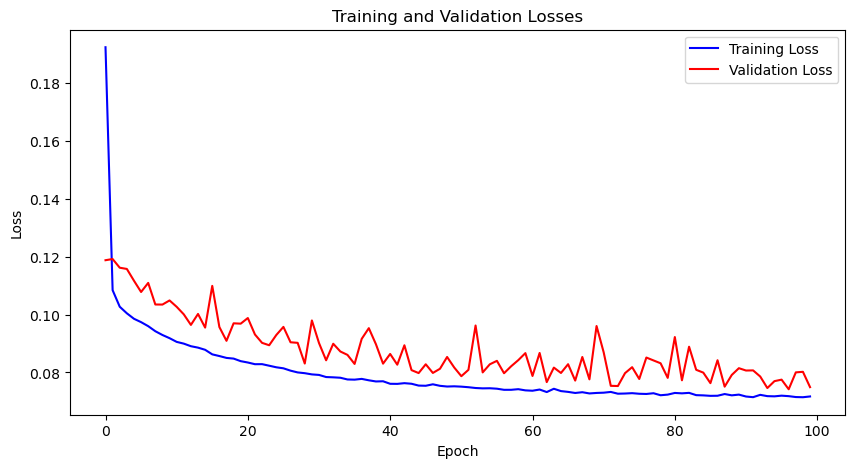

In [57]:
import matplotlib.pyplot as plt

# 1. Initialize Lists for Storing Losses
train_losses = []
val_losses = []

n_epochs = 100
print_every = 10  # Print results every 10 epochs

for epoch in range(1, n_epochs+1):
    # Training
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Evaluation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            predictions = model(X_batch)
            loss = criterion(predictions.squeeze(), y_batch)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # 2. Append Losses to Lists during Training
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Print results
    if epoch == 1 or epoch % print_every == 0:
        print(f'Epoch: {epoch}/{n_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}')

# 3. Plot Losses after Training
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# LSTM Model Training